In [2]:
import xarray as xr
import rioxarray as rxr
import pyproj
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
import numpy as np
from pyeto import fao
import numpy as np

# Pull in boundary data

In [27]:
lcc_proj = "+proj=lcc +lat_0=50 +lon_0=-107 +lat_1=50 +lat_2=50 +x_0=5632642.22547 +y_0=4612545.65137 +datum=WGS84 +units=m +no_defs" #my custom CRS
ucrb_boundary = gpd.read_file('../basin_characteristics/Upper_Colorado_River_Basin_Boundary.json')
ucrb_boundary_4326 = ucrb_boundary.copy()
ucrb_boundary=ucrb_boundary.to_crs(lcc_proj)

hcdn_boundaries = gpd.read_file('../data/geodata/basin_station_sntl.json')
hcdn_boundaries=hcdn_boundaries.set_crs(epsg=32613,allow_override=True)
hcdn_boundaries_4326=hcdn_boundaries.to_crs(4326)


# Pull in Terraclime data

In [28]:
terraclimate_pet = xr.open_dataset('../data/etdata/agg_terraclimate_pet_1958_CurrentYear_GLOBE.nc')
terraclimate_ppt = xr.open_dataset('../data/precipdata/agg_terraclimate_ppt_1958_CurrentYear_GLOBE.nc')
terraclimate_tmin = xr.open_dataset('../data/etdata/agg_terraclimate_tmin_1958_CurrentYear_GLOBE.nc')
terraclimate_tmax = xr.open_dataset('../data/etdata/agg_terraclimate_tmax_1958_CurrentYear_GLOBE.nc')
# resample to daily data
# terraclimate_pet_daily = terraclimate_pet.resample(time='1D').interpolate('cubic')
# convert to a raster and change crs to match the UCRB boundary
terraclimate_pet = terraclimate_pet.rio.write_crs(4326)
terraclimate_ppt = terraclimate_ppt.rio.write_crs(4326)
terraclimate_tmin = terraclimate_tmin.rio.write_crs(4326)
terraclimate_tmax = terraclimate_tmax.rio.write_crs(4326)

### Set boundary to east river

In [29]:

tmp1 = hcdn_boundaries_4326[hcdn_boundaries_4326.gage == '09112500']
pet_trc = terraclimate_pet.rio.clip(tmp1.geometry).mean(dim=['lat', 'lon'])
ppt_trc = terraclimate_ppt.rio.clip(tmp1.geometry).mean(dim=['lat', 'lon'])
tmin_trc = terraclimate_tmin.rio.clip(tmp1.geometry).mean(dim=['lat', 'lon'])
tmax_trc = terraclimate_tmax.rio.clip(tmp1.geometry).mean(dim=['lat', 'lon'])

In [30]:
### save if needed
# pet_trc.resample(time='1D').interpolate('cubic').to_netcdf('../data/etdata/east_river_terraclime_pet.nc')
# pet_trc.to_netcdf('../data/etdata/east_river_terraclime_pet_monthly.nc')
# ppt_trc.to_netcdf('../data/precipdata/east_river_terraclime_ppt_monthly.nc')

# Upsample to UCRB (if needed)

In [31]:
pet_ds = rxr.open_rasterio('../data/etdata/pevap.mon.mean.nc')[0].drop(['lat','lon','spatial_ref', 'Lambert_Conformal'])
et_ds = rxr.open_rasterio('../data/etdata/evap.mon.mean.nc')[0].drop(['lat','lon','spatial_ref', 'Lambert_Conformal'])
et_ds=et_ds.rio.write_crs(lcc_proj)
pet_ds = pet_ds.rio.write_crs(lcc_proj)

/home/dlhogan/.conda/envs/act_env/lib/python3.7/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/dlhogan/.conda/envs/act_env/lib/python3.7/site-packages/rioxarray/_io.py:841: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  warnings.warn(str(rio_warning.message), type(rio_warning.message))
/home/dlhogan/.conda/envs/act_env/lib/python3.7/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/dlhogan/.conda/envs/act_env/lib/python3.7/site-packages/rioxarray/_io.py:841: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  warnings.warn(str(rio_warning.message), t

In [32]:
east_river_prism_spring_ppt = np.array([132.50640869, 161.00164795, 113.92868042, 183.50294495,
       191.17182922, 179.4776001 , 227.3445282 , 177.95184326,
       393.7897644 , 169.48959351, 252.80996704, 191.27253723,
       306.93130493, 157.4598999 , 191.35449219,  57.79572296,
       207.99324036, 169.39666748, 188.7718811 , 120.08251953,
       132.17991638, 178.49324036, 225.05078125, 197.32672119,
       226.85133362,  74.01044464, 182.01896667, 150.55526733,
       238.73526001, 170.80326843, 122.61911774, 124.73542023,
       224.92695618, 123.7173233 , 117.88620758, 132.83822632])

In [33]:
pet_ds_clipped_ucrb = pet_ds.rio.clip(ucrb_boundary.geometry)
pet_ds_masked_ucrb=pet_ds_clipped_ucrb.where(pet_ds_clipped_ucrb['pevap']!=9.96921e+36)

# convert to mm equivalent
pet_ds_masked_ucrb['pevap'] = pet_ds_masked_ucrb['pevap']*30
pet_ds_masked_ucrb['pevap'].attrs['units']='mm'

# dx = 32462.98850575/32.46298850575
# lon = np.arange(pet_ds_masked_ucrb.x.min(), pet_ds_masked_ucrb.x.max(),dx)
# lat = np.arange(pet_ds_masked_ucrb.y.min(), pet_ds_masked_ucrb.y.max(),dx)
# pet_ds_masked_ucrb=pet_ds_masked_ucrb.interp(x=lon, y=lat, method='linear')
# PET for UCRB as a whole
pet_ds_masked_ucrb['WY'] = pet_ds_masked_ucrb.time.dt.year.where(pet_ds_masked_ucrb.time.dt.month<10,pet_ds_masked_ucrb.time.dt.year+1)
pet_wy_ds_mean_ucrb = pet_ds_masked_ucrb.where(~pet_ds_masked_ucrb['WY'].isin([1979,2023, 2016])).groupby('WY').sum().mean(dim='x').mean(dim='y')
norm_pet_ds_ucrb = ((pet_wy_ds_mean_ucrb-pet_wy_ds_mean_ucrb.mean(dim='WY'))/pet_wy_ds_mean_ucrb.std(dim='WY'))['pevap']

In [34]:
et_ds_clipped_ucrb = et_ds.rio.clip(ucrb_boundary.geometry)
et_ds_masked_ucrb=et_ds_clipped_ucrb.where(et_ds_clipped_ucrb['evap']!=9.96921e+36)

# convert to mm equivalent
et_ds_masked_ucrb['evap'] = et_ds_masked_ucrb['evap']*1000
et_ds_masked_ucrb['evap'].attrs['units']='mm'

# dx = 32462.98850575/32.46298850575
# lon = np.arange(et_ds_masked_ucrb.x.min(), et_ds_masked_ucrb.x.max(),dx)
# lat = np.arange(et_ds_masked_ucrb.y.min(), et_ds_masked_ucrb.y.max(),dx)
# et_ds_masked_ucrb=et_ds_masked_ucrb.interp(x=lon, y=lat, method='linear')
# et for UCRB as a whole
et_ds_masked_ucrb['WY'] = et_ds_masked_ucrb.time.dt.year.where(et_ds_masked_ucrb.time.dt.month<10,et_ds_masked_ucrb.time.dt.year+1)
# et_wy_ds_mean_ucrb = et_ds_masked_ucrb.where(~et_ds_masked_ucrb['WY'].isin([1979,2023])).groupby('WY').sum().mean(dim=['x','y'])
# norm_et_ds_ucrb = ((et_wy_ds_mean_ucrb-et_wy_ds_mean_ucrb.mean(dim='WY'))/et_wy_ds_mean_ucrb.std(dim='WY'))['evap']

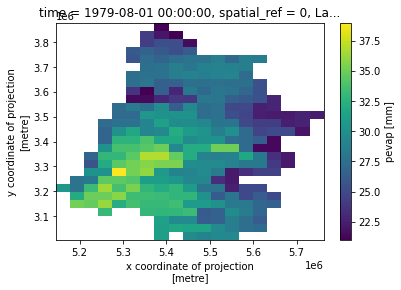

In [35]:
# import resampling
from rasterio.enums import Resampling
# pet_ds_clipped_ucrb_rpj = pet_ds_masked_ucrb.rio.reproject(dst_crs=32613, resampling=Resampling.nearest)
# pet_ds_clipped_ucrb_rpj = pet_ds_clipped_ucrb_rpj.where(pet_ds_clipped_ucrb_rpj < 1000)
pet_ds_masked_ucrb.pevap.isel(time=7).plot()

In [36]:
wrf_ppt = xr.open_dataset('/storage/dlhogan/sos/data/wrf_climatology_precip.nc')
spring_ppt = wrf_ppt.where(wrf_ppt['XTIME'].dt.month.isin([4,5,6]),drop=True).groupby('XTIME.year').sum()
mean_spring_ppt = spring_ppt.mean(dim=['south_north', 'west_east'])

In [60]:
prism_tmean = rxr.open_rasterio('../data/etdata/prism_tmean_4km_all.nc')
prism_tmean = prism_tmean.where(prism_tmean>-100,drop=True)
# prism_tmean
# take a look at the data
tmp = hcdn_boundaries[hcdn_boundaries.gage == '09112500']
ucrb_temp = prism_tmean.rio.clip(tmp.geometry)
ucrb_temp = ucrb_temp.where(ucrb_temp>-100,drop=True)
mean_ucrb_temp = ucrb_temp.mean(dim=['x','y'])
spring_mean_ucrb_temp = mean_ucrb_temp.where(mean_ucrb_temp['month'].dt.month.isin([4,5,6]),drop=True).groupby('month.year').mean()

prism_monthly_ppt = xr.open_dataset('../data/precipdata/prism_hcdn_seasonal_ppt_14710.nc').sel(variable='09112500',dim_1='ppt')


<xarray.Dataset>
Dimensions:                        (month: 511)
Coordinates:
  * month                          (month) datetime64[ns] 1895-01-01 ... 2022...
    dim_1                          <U3 'ppt'
    variable                       <U8 '09112500'
Data variables:
    __xarray_dataarray_variable__  (month) float64 ...

In [39]:
from pyeto import thornthwaite, monthly_mean_daylight_hours, deg2rad
lat = deg2rad(38.87626) 
thornthwaite_pet_df = pd.DataFrame(index=range(1987,2021), columns=range(1,13))
for year in range(1987,2021):
    mmdlh = monthly_mean_daylight_hours(lat, year=year)
    temp = mean_ucrb_temp.where(mean_ucrb_temp['month'].dt.year==year,drop=True)
    thornthwaite_pet_df.loc[year] = np.array(thornthwaite(temp.values, mmdlh))

# Pull in WRF data to estimate PET

In [ ]:
# df = pd.DataFrame(columns=['value', 'year', 'month', 'variable'])
# for year in range(1987,2021):
#     print(f'Processing year {year}...')
#     example_ds = xr.open_mfdataset(f'/storage/dlhogan/sos/data/WRF/WY{year}/*.nc')
#     # resample to daily mean
#     ppt = example_ds.HR_PRCP.resample(XTIME='1M').sum().mean(dim=['south_north', 'west_east'])
#     # get the spatial average
#     example_ds = example_ds.mean(dim=['south_north', 'west_east']).resample(XTIME='1M').mean()

#     ### Calculate necessary variables for PET calculation
#     wm2_to_mj2day = 0.0864
#     # calculate net radiation
#     net_rad = fao.net_rad(ni_sw_rad = example_ds['SWDOWN']*wm2_to_mj2day,
#                 no_lw_rad = example_ds['GLW']*wm2_to_mj2day,)
#     # get average daily 2m temperature
#     t = example_ds['T2'].compute()
#     if year == 1987:
#         t_pre=280
#     else:
#         t_pre = t.values[0]

#     # get the arithmetic mean of U10 and V10 daily wind speed
#     u10 = example_ds['U10']
#     v10 = example_ds['V10']
#     ws = np.sqrt(u10**2 + v10**2)
#     # calculate the saturated vapor pressure
#     es = 6.11 * np.exp((2.5e6/461.5) * (1/273.15 - 1/(t.values))) # kilopascal
#     # calculate the actual vapor pressure
#     ea = (example_ds['Q2'] * example_ds['PSFC'] / (0.622 + 0.378 * example_ds['Q2'])).compute()/1000 # kiloPascal
#     # calculate the slope of the saturation vapor pressure curve
#     delta = 4098 * (0.6108 * np.exp(17.27 * (t.values-273.15) / (t.compute().values-35.86))) / (t.values-35.86)**2 
#     # calculate the psychrometric constant
#     psy = fao.psy_const(example_ds['PSFC']/1000).compute()
#     # calculate the mean soil flux estiamtion
#     pre_t = np.roll(t.values,1)
#     pre_t[0] = t_pre
#     sh = fao.monthly_soil_heat_flux2(pre_t-273.15,t.values-273.15)
#     # calculate the PET
#     pet = fao.fao56_penman_monteith(net_rad.values,
#                             t.values,
#                             ws.values,
#                             es,
#                             ea.values,
#                             delta,
#                             psy.values,
#                             shf=sh)  
#     # add ppt to df with measuuremnet = ppt and month going from 10,11,12,1,2,3,4,5,6,7,8,9
#     df = pd.concat([df,
#                     pd.DataFrame({'value':pet,'variable':'pet','month':[10,11,12,1,2,3,4,5,6,7,8,9],'year':year}),
#                     pd.DataFrame({'value':ppt,'variable':'ppt','month':[10,11,12,1,2,3,4,5,6,7,8,9],'year':year}),
#                     pd.DataFrame({'value':t.values,'variable':'t','month':[10,11,12,1,2,3,4,5,6,7,8,9],'year':year})],
#                     ignore_index=True)

Processing year 1987...
Processing year 1988...
Processing year 1989...
Processing year 1990...
Processing year 1991...
Processing year 1992...
Processing year 1993...
Processing year 1994...
Processing year 1995...
Processing year 1996...
Processing year 1997...
Processing year 1998...
Processing year 1999...
Processing year 2000...
Processing year 2001...
Processing year 2002...
Processing year 2003...
Processing year 2004...
Processing year 2005...
Processing year 2006...
Processing year 2007...
Processing year 2008...
Processing year 2009...
Processing year 2010...
Processing year 2011...
Processing year 2012...
Processing year 2013...
Processing year 2014...
Processing year 2015...
Processing year 2016...
Processing year 2017...
Processing year 2018...
Processing year 2019...
Processing year 2020...


In [40]:
# df.to_csv('../data/etdata/east_river_pet_wrf.csv')
df = pd.read_csv('../data/etdata/east_river_pet_wrf.csv', index_col=0)

# Plot PET against Spring P colored by Tmean

In [41]:
tmean_trc = (tmax_trc.tmax + tmin_trc.tmin)/2
tdiff_trc = tmax_trc.tmax - tmin_trc.tmin


In [42]:
spring_totals_terraclime_pet = pet_trc['pet'].where(pet_trc.time.dt.month.isin([4,5,6])).groupby('time.year').sum('time').sel(year=slice(1989,2020))
spring_totals_terraclime_ppt = ppt_trc['ppt'].where(ppt_trc.time.dt.month.isin([4,5,6])).groupby('time.year').sum('time').sel(year=slice(1989,2020))
spring_tmin_terraclime = tmin_trc.tmin.where(tmin_trc.time.dt.month.isin([4,5,6])).groupby('time.year').mean('time').sel(year=slice(1989,2020))
spring_tmax_terraclime = tmax_trc.tmax.where(tmax_trc.time.dt.month.isin([4,5,6])).groupby('time.year').mean('time').sel(year=slice(1989,2020))
spring_tmean_terraclime = (tmean_trc.where(tmean_trc.time.dt.month.isin([4,5,6]))).groupby('time.year').mean('time').sel(year=slice(1989,2020))
spring_tdiff_terraclime = tdiff_trc.where(tdiff_trc.time.dt.month.isin([4,5,6])).groupby('time.year').mean('time').sel(year=slice(1989,2020))

spring_tmean_terraclime_anomaly = spring_tmean_terraclime - spring_tmean_terraclime.mean('year')

### Same plot but for spring PET and ET

In [44]:
import scipy.stats as stats

/home/dlhogan/.conda/envs/act_env/lib/python3.7/site-packages/IPython/core/pylabtools.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


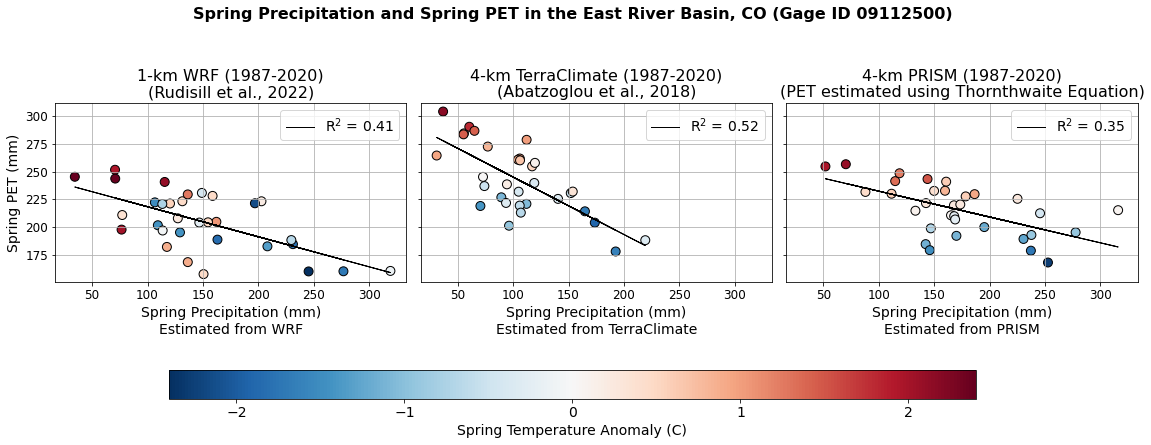

In [45]:
fig, axs = plt.subplots(ncols=3,figsize=(16,8), sharex=True, sharey=True, tight_layout=True)
# WRF Estimates
ax=axs[0]
# create the pivot table for spring conditions
spring_totals = df[df['month'].isin([4,5,6])].pivot_table(index='year',columns='variable',values='value',aggfunc='sum').loc[1989:2020]
spring_total_temp = df[df['month'].isin([4,5,6])].pivot_table(index='year',columns='variable',values='value',aggfunc='mean').loc[1989:2020]
spring_temperature_anomaly = spring_total_temp.t - spring_total_temp.t.mean()
# from the pivot table plot spring precipitation against spring pet
cax1 = ax.scatter(spring_totals['ppt'],
           spring_totals['pet']*3,
           c=spring_temperature_anomaly,
           cmap='RdBu_r',
           vmin=-2.4,
           vmax=2.4,
           s=80, 
           ec='k')

# add a best fit line with r2 in the legend
slope, intercept, r_value, p_value1, std_err = stats.linregress(spring_totals['ppt'],spring_totals['pet']*3, alternative='less')
ax.plot(spring_totals['ppt'], slope*spring_totals['ppt']+ intercept, '-', color='k', linewidth=1, label='R$^2$ = '+str(round(r_value**2,2)))
# add xlabel, ylabel, and title and make the sizes bigger
ax.set_xlabel('Spring Precipitation (mm)\nEstimated from WRF',fontsize=14)
ax.set_ylabel('Spring PET (mm)',fontsize=14)
ax.set_title('1-km WRF (1987-2020)\n(Rudisill et al., 2022)',fontsize=16)
# increase the ticklabel size for x and y axes
ax.tick_params(axis='both', which='major', labelsize=12)
ax.legend(fontsize=14)

ax=axs[1]
# from the pivot table plot spring precipitation against spring pet
cax = ax.scatter(spring_totals_terraclime_ppt,
           spring_totals_terraclime_pet.values,
           c=spring_tmean_terraclime_anomaly,
           vmin=-2.4,
           vmax=2.4,
           cmap='RdBu_r',
           s=80, 
           ec='k')

# add a best fit line with r2 in the legend
slope, intercept, r_value, p_value, std_err = stats.linregress(spring_totals_terraclime_ppt,spring_totals_terraclime_pet, alternative='less')
ax.plot(spring_totals_terraclime_ppt, slope*spring_totals_terraclime_ppt + intercept, '-', color='k', linewidth=1, label='R$^2$ = '+str(round(r_value**2,2)))
# add xlabel, ylabel, and title and make the sizes bigger
ax.set_title('4-km TerraClimate (1987-2020)\n(Abatzoglou et al., 2018)',fontsize=16)
ax.set_xlabel('Spring Precipitation (mm)\nEstimated from TerraClimate',fontsize=14)
ax.legend(fontsize=14)
# increase the ticklabel size for x and y axes
ax.tick_params(axis='both', which='major', labelsize=12)

# PRISM Estimates
ax = axs[2]
prism_temperature_anomaly = spring_mean_ucrb_temp.sel(year=slice(1989,2020)) - spring_mean_ucrb_temp.sel(year=slice(1989,2020)).mean()
# from the pivot table plot spring precipitation against spring pet
cax1 = ax.scatter(mean_spring_ppt.sel(year=slice(1989,2020)).precip.values,
           1.33*thornthwaite_pet_df[[4,5,6]].sum(axis=1).loc[1989:],
           c=prism_temperature_anomaly,
           cmap='RdBu_r',
           vmin=-2.4,
           vmax=2.4,
           s=80, 
           ec='k')

# add a best fit line with r2 in the legend
slope, intercept, r_value, p_value1, std_err = stats.linregress(mean_spring_ppt.sel(year=slice(1989,2020)).precip.values,1.33*thornthwaite_pet_df[[4,5,6]].sum(axis=1).loc[1989:], alternative='less')
ax.plot(mean_spring_ppt.sel(year=slice(1989,2020)).precip.values, slope*mean_spring_ppt.sel(year=slice(1989,2020)).precip.values + intercept, '-', color='k', linewidth=1, label='R$^2$ = '+str(round(r_value**2,2)))
# add xlabel, ylabel, and title and make the sizes bigger
ax.set_xlabel('Spring Precipitation (mm)\nEstimated from PRISM',fontsize=14)
# ax.set_ylabel('Spring PET (Thornthwaite) (mm)',fontsize=14)
ax.set_title('4-km PRISM (1987-2020)\n(PET estimated using Thornthwaite Equation)',fontsize=16)
# increase the ticklabel size for x and y axes
ax.tick_params(axis='both', which='major', labelsize=12)
ax.legend(fontsize=14)

# increase the white space between the title and the subplots
plt.subplots_adjust(wspace=0.05)
fig.suptitle('Spring Precipitation and Spring PET in the East River Basin, CO (Gage ID 09112500)',fontsize=16, fontweight='bold', y=0.8)
# add colorbar on the bottom of the figure
cbar_ax = fig.add_axes([0.15, 0.12, 0.7, 0.05])
cbar = plt.colorbar(cax1, cax=cbar_ax, orientation='horizontal')
cbar.set_label('Spring Temperature Anomaly (C)',fontsize=14)
# increase the ticklabel size for the colorbar
cbar.ax.tick_params(labelsize=14)
for ax in axs:
    ax.tick_params(axis='both', which='major', labelsize=12)
    if ax == axs[0]:
      ax.set_ylabel('Spring PET (mm)',fontsize=14)
   #  ax.set_xlabel('Spring Precipitation (mm)',fontsize=14)
    ax.set_aspect('equal', 'box')
    ax.legend(fontsize=14)
    ax.grid()

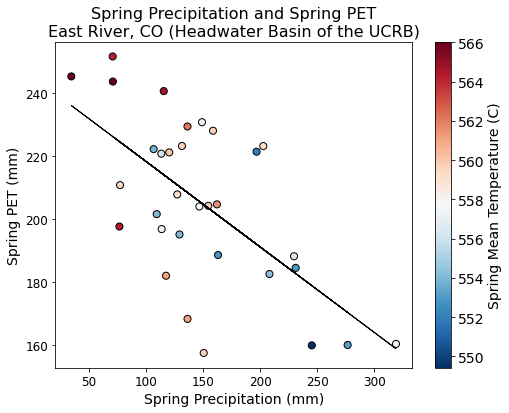

In [46]:
fig, ax = plt.subplots(figsize=(8,6))
# create the pivot table for spring conditions
spring_totals = df[df['month'].isin([4,5,6])].pivot_table(index='year',columns='variable',values='value',aggfunc='sum').loc[1989:]
spring_total_temp = df[df['month'].isin([4,5,6])].pivot_table(index='year',columns='variable',values='value',aggfunc='mean').loc[1989:]
# from the pivot table plot spring precipitation against spring pet
cax = ax.scatter(spring_totals.ppt,
           spring_totals.pet*3,
           c=spring_totals.t-273.15,
           cmap='RdBu_r',
           s=50, 
           ec='k')
# add a colorbar
cbar = plt.colorbar(cax)
cbar.set_label('Spring Mean Temperature (C)',fontsize=14)
# increase the ticklabel size for the colorbar
cbar.ax.tick_params(labelsize=14)
# add a best fit line with r2 in the legend
slope, intercept, r_value, p_value, std_err = stats.linregress(spring_totals.ppt,spring_totals.pet*3)
m, b = np.polyfit(spring_totals.ppt,spring_totals.pet*3, 1)
ax.plot(spring_totals.ppt, m*spring_totals.ppt + b, '-', color='k', linewidth=1)
# add xlabel, ylabel, and title and make the sizes bigger
ax.set_xlabel('Spring Precipitation (mm)',fontsize=14)
ax.set_ylabel('Spring PET (mm)',fontsize=14)
ax.set_title('Spring Precipitation and Spring PET\nEast River, CO (Headwater Basin of the UCRB)',fontsize=16)
# increase the ticklabel size for x and y axes
ax.tick_params(axis='both', which='major', labelsize=12)
# ax.set_ylim(50,90)

0.969788248732122
0.7684024187469468


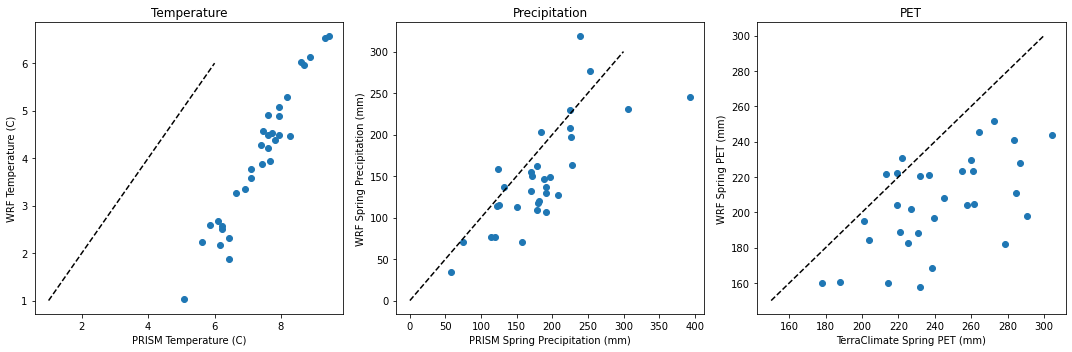

In [47]:
fig, axs = plt.subplots(1,3, figsize=(15,5))
axs[0].scatter(spring_mean_ucrb_temp.sel(year=slice(1989,2020)), spring_total_temp['t']-273.15, label='T')
# pearson correlation
r, p = stats.pearsonr(spring_mean_ucrb_temp.sel(year=slice(1989,2020)), spring_total_temp['t']-273.15)
print(r)
axs[0].plot([1, 6], [1, 6], 'k--')
axs[0].set_xlabel('PRISM Temperature (C)')
axs[0].set_ylabel('WRF Temperature (C)')
axs[0].set_title('Temperature')

axs[1].scatter(east_river_prism_spring_ppt[2:-2], spring_totals['ppt'])
axs[1].plot([0, 300], [0, 300], 'k--')
axs[1].set_xlabel('PRISM Spring Precipitation (mm)')
axs[1].set_ylabel('WRF Spring Precipitation (mm)')
axs[1].set_title('Precipitation')
# pearson correlation
r, p = stats.pearsonr(east_river_prism_spring_ppt[2:-2], spring_totals['ppt'])
print(r)
axs[2].scatter(spring_totals_terraclime_pet, spring_totals['pet']*3)
axs[2].plot([150, 300], [150, 300], 'k--')
axs[2].set_xlabel('TerraClimate Spring PET (mm)')
axs[2].set_ylabel('WRF Spring PET (mm)')
axs[2].set_title('PET')

# make the plot look nice
plt.tight_layout()


In [69]:
prism_spring_ppt = prism_monthly_ppt['__xarray_dataarray_variable__'].where(prism_monthly_ppt['month'].dt.month.isin([4])).groupby('month.year').sum('month')

In [70]:
prism_spring_ppt

<xarray.DataArray '__xarray_dataarray_variable__' (year: 128)>
array([219.39227295, 147.60429382, 193.87194824, 167.29646301,
       124.7022934 , 343.01257324, 264.53308105, 134.95033264,
       161.97695923, 209.71859741, 319.22412109, 219.52304077,
       220.09590149, 179.03155518, 163.62626648, 118.69290924,
       151.19822693, 201.59307861, 146.55693054, 217.81384277,
       197.1736908 , 119.03964233, 191.48355103, 159.44163513,
       122.24517822, 225.08540344, 244.54833984, 165.04008484,
       173.70599365, 138.10528564, 113.2252121 , 222.92445374,
       173.73904419, 210.27836609, 126.60801697, 106.61123657,
       152.37284851, 154.67030334, 217.55079651, 100.79574585,
       303.39028931, 137.93280029, 177.89738464, 282.81448364,
        79.36833954, 137.39013672, 231.46360779, 198.25741577,
       173.37117004, 266.70925903, 193.76249695, 214.56297302,
       320.97610474, 243.72651672, 211.84848022, 144.72361755,
       239.36413574, 126.17362213, 212.22723389, 104.96327972,
       148.5227356 , 139.92488098, 342.90509033, 140.72187805,
       205.72633362, 108.51711273, 193.41418457, 187.39698792,
       116.49523163, 192.52383423, 206.26748657, 171.5       ,
       196.83358765, 147.04719543, 232.40240479, 198.1242218 ,
       149.59745789, 177.46374512, 244.28723145, 161.95948792,
       163.57569885, 137.88146973, 131.7023468 , 180.94975281,
       228.6937561 , 169.41796875, 217.68664551, 148.07722473,
       334.7862854 , 322.56497192, 236.12812805, 222.5198822 ,
       132.50640869, 161.00164795, 113.92868042, 183.50294495,
       191.17182922, 179.4776001 , 227.3445282 , 177.95184326,
       393.7897644 , 169.48959351, 252.80996704, 191.27253723,
       306.93130493, 157.4598999 , 191.35449219,  57.79572296,
       207.99324036, 169.39666748, 188.7718811 , 120.08251953,
       132.17991638, 178.49324036, 225.05078125, 197.32672119,
       226.85133362,  74.01044464, 182.01896667, 150.55526733,
       238.73526001, 170.80326843, 122.61911774, 124.73542023,
       224.92695618, 123.7173233 , 117.88620758, 132.83822632])
Coordinates:
    dim_1     <U3 'ppt'
    variable  <U8 '09112500'
  * year      (year) int64 1895 1896 1897 1898 1899 ... 2018 2019 2020 2021 2022

Text(0.5, 1.0, 'Temporal Trend in Spring Temperature')

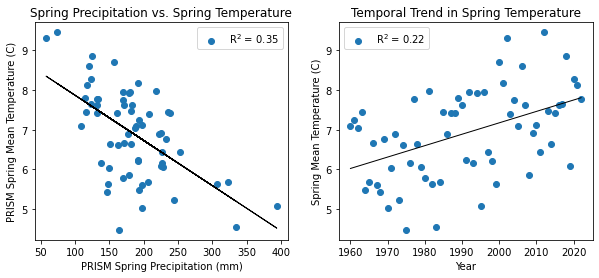

In [91]:
fig, axs = plt.subplots(ncols=2,figsize=(10,4))
years_of_interest=slice(1960,2022)
ax=axs[0]
# add an r2 value
slope, intercept, r_value, p_value, std_err = stats.linregress(prism_spring_ppt.sel(year=years_of_interest),spring_mean_ucrb_temp.sel(year=years_of_interest))
ax.scatter(prism_spring_ppt.sel(year=years_of_interest),spring_mean_ucrb_temp.sel(year=years_of_interest), label='R$^2$ = '+str(round(r_value**2,2)))
# add best fit line
ax.plot(prism_spring_ppt.sel(year=years_of_interest), slope*prism_spring_ppt.sel(year=years_of_interest) + intercept, '-', color='k', linewidth=1)
ax.legend()
ax.set_ylabel('PRISM Spring Mean Temperature (C)')
ax.set_xlabel('PRISM Spring Precipitation (mm)')
ax.set_title('Spring Precipitation vs. Spring Temperature')

ax=axs[1]
# add an r2 value
slope, intercept, r_value, p_value, std_err = stats.linregress(spring_mean_ucrb_temp.sel(year=years_of_interest).year,spring_mean_ucrb_temp.sel(year=years_of_interest))
ax.scatter(spring_mean_ucrb_temp.sel(year=years_of_interest).year,spring_mean_ucrb_temp.sel(year=years_of_interest), label='R$^2$ = '+str(round(r_value**2,2)))
# add best fit line
ax.plot(spring_mean_ucrb_temp.sel(year=years_of_interest).year, slope*spring_mean_ucrb_temp.sel(year=years_of_interest).year + intercept, '-', color='k', linewidth=1)
ax.legend()
ax.set_xlabel('Year')
ax.set_ylabel('Spring Mean Temperature (C)')
ax.set_title('Temporal Trend in Spring Temperature')